In [1]:
#importar bibliotecas necessárias
import pandas as pd
import numpy as np

In [2]:
#carregar o df
df = pd.read_csv('FCLA_3_meses.csv', skiprows=2)

#colocar as colunas no lugar correto
df.columns = df.iloc[0]
df = df[1:]

#retirar a coluna NaN
df = df.drop(columns=[col for col in df.columns if pd.isna(col)])

#retirar as colunas que n iremos utilizar
df = df.drop(columns=['Classe','Bolsa / Fonte','Tipo de Ativo','Ativo /\nCancelado', 'Código'])

#mudar o nome das colunas para melhor entendimento
anos = range(2014,2025)
trimestres = ['T1', 'T2', 'T3', 'T4'] 
novo_nomes = [f"FCLA_{ano}_{tri}" for ano in anos for tri in trimestres]
df.columns = [df.columns[0]] + novo_nomes[:len(df.columns) - 1]
df = df.dropna(how='all', axis=1)


In [3]:
# Processando do formato wide pro formato (long) - empilhado
# Remover colunas vazias e espaços extras
df = df.dropna(axis=1, how='all')
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

# Renomear a coluna de empresas
df = df.rename(columns={'Name': 'Empresa'})

# Transformar para formato long
df_long = pd.melt(
    df,
    id_vars=['Nome'],
    value_vars=[col for col in df.columns if col.startswith('FCLA_')],
    var_name='Date',
    value_name='FCLA'
)

# Ajustar o formato da data (ex: FCLA_2014_T1 -> 2014-T1)
df_long['Date'] = df_long['Date'].str.replace('FCLA_', '').str.replace('_', '-')

# Remover linhas com valores inválidos (como '-')
df_long = df_long[df_long['FCLA'] != '-']

# Converter FCLA para numérico (tratando vírgulas como separadores decimais)
df_long['FCLA'] = df_long['FCLA'].str.replace(',', '.').str.replace('.', '').astype(float)

# Ordenar por Empresa e Date
df_long = df_long.sort_values(['Nome', 'Date']).reset_index(drop=True)

In [4]:
#Reordenando os dados usando pd.to_datetime()
# Passo 1: Extrair ano e trimestre
df_long[['Ano', 'Trimestre']] = df_long['Date'].str.split('-', expand=True)
df_long['Trimestre'] = df_long['Trimestre'].str.replace('T', '').astype(int)

# Passo 2: Mapear trimestre para mês (T1=1, T2=4, T3=7, T4=10)
trimestre_para_mes = {1: 1, 2: 4, 3: 7, 4: 10}
df_long['Mes'] = df_long['Trimestre'].map(trimestre_para_mes)

# Passo 3: Criar uma string de data no formato 'AAAA-MM-DD'
df_long['Data'] = (
    df_long['Ano'] + '-' + 
    df_long['Mes'].astype(str).str.zfill(2) + '-01'
)

# Passo 4: Converter para datetime
df_long['Data'] = pd.to_datetime(df_long['Data'])

# Remover colunas auxiliares (opcional)
df_long = df_long.drop(['Ano', 'Trimestre', 'Mes'], axis=1)

# Ordenar por Empresa e Data
df_long = df_long.sort_values(['Nome', 'Data'])

# Dropar a coluna Date antiga e reordenar 
df_long = df_long.drop(columns=['Date'])
df_long = df_long[['Nome', 'Data', 'FCLA']]

# Exibir resultado
df_long

,Nome,Data,FCLA
0,3tentos,2021-01-01,3770.0
1,3tentos,2021-04-01,-350083.0
2,3tentos,2021-07-01,186785.0
3,3tentos,2021-10-01,-119487.0
4,3tentos,2022-01-01,-320523.0
...,...,...,...
12099,Zamp S.A.,2023-07-01,5425.0
12100,Zamp S.A.,2023-10-01,93978.0
12101,Zamp S.A.,2024-01-01,-59692.0
12102,Zamp S.A.,2024-04-01,10855.0


In [6]:
df_long = df_long.sort_values(by=['Nome', 'Data'])

df_long["g"] = df_long.groupby("Nome")["FCLA"].pct_change()

df_long = df_long.dropna(subset=['g'])

df_long = df_long[np.isfinite(df_long["g"])]
    
#medias dos g
media_g = df_long['g'].mean()
dp_g = df_long['g'].std()

print(media_g)
print(dp_g)

empresas_unicas = df_long['Nome'].unique()
print(f'Qtd de empresas unicas: {len(empresas_unicas)}')
df_long.to_csv('g_FCLA_teste.csv')


10.72751515728877
1377.9468134169963
Qtd de empresas unicas: 338


In [39]:
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Carregar os dados
df = df_long

df = df[np.isfinite(df["g"])]
# Ignorar Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df['Data'] = pd.to_datetime(df['Data'])  # Converter para datetime

def expanding_window_knn(df, k=1): #melhor fit k = 1
    results = []
    maes, rmses = [], []
    start_time = time.time()

    #medias dos g
    media_g = df['g'].mean()
    dp_g = df['g'].std()

    for empresa in df['Nome'].unique():
        df_empresa = df[df['Nome'] == empresa].sort_values(by='Data').reset_index(drop=True)
        
        if len(df_empresa) < k:
            continue  # Ignora empresas com menos de k registros
        
        X, y = [], []
        scaler = MinMaxScaler()
        
        y_real_list, y_pred_list = [], []
        
        for i in range(len(df_empresa)):
            if i < k:
                continue
            
            X_train = df_empresa['g'].iloc[:i].values.reshape(-1, 1)

            if not np.all(np.isfinite(X_train)):
                continue  # Pula esse loop se houver problemas

            y_train = df_empresa['g'].iloc[:i].values
            X_test = df_empresa['g'].iloc[i].reshape(-1, 1)
              
            
            # Normalizar os dados
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test.reshape(-1, 1))
            
            # Criar e treinar o modelo
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)
            
            # Fazer a previsão
            y_pred = knn.predict(X_test)[0]
            y_real = df_empresa['g'].iloc[i]
            erro_abs = abs(y_real - y_pred)
            
            results.append([empresa, df_empresa['Data'].iloc[i], y_real, y_pred, erro_abs])
            
            y_real_list.append(y_real)
            y_pred_list.append(y_pred)

        
        # Calcular métricas apenas se houver previsões
        if len(y_real_list) > 0 and len(y_pred_list) > 0:
            mae = mean_absolute_error(y_real_list, y_pred_list)
            rmse = mean_squared_error(y_real_list, y_pred_list, squared=False)
            maes.append(mae)
            rmses.append(rmse)
            r2 = r2_score(y_real_list, y_pred_list)

            X_train_final = df_empresa['g'].iloc[:-1].values.reshape(-1, 1)
            y_train_final = df_empresa['g'].iloc[:-1].values
            X_test_final = df_empresa['g'].iloc[-1].reshape(-1, 1)
            y_test_final = df_empresa['g'].iloc[-1]
            
            X_train_final = scaler.fit_transform(X_train_final)
            X_test_final = scaler.transform(X_test_final)
            
            knn.fit(X_train_final, y_train_final)
            train_mse = mean_squared_error(y_train_final, knn.predict(X_train_final))
            test_mse = mean_squared_error([y_test_final], knn.predict(X_test_final))  # Corrigido
            divd = (train_mse/test_mse)
    
    total_time = time.time() - start_time

    
    
    # Criar um DataFrame com os resultados
    df_results = pd.DataFrame(results, columns=['Empresa', 'Data', 'G Real', 'G Previsto', 'Erro Absoluto'])
    
    # Salvar como CSV
    df_results.to_csv('previsoes_knn_g.csv', index=False)
    print("Arquivo 'previsoes_knn.csv' salvo com sucesso!")
    print(f"Tempo total de computação: {total_time:.2f} segundos")
    if len(maes) > 0 and len(rmses) > 0:
        print(f"MAE: {mae}")
        print(f"RMSE: {rmse}")
    else:
        print("Não foi possível calcular MAE e RMSE devido à falta de previsões válidas.")
    print(f'R2 da regressão: {r2}')
    print(f"MSE no Treino: {train_mse:.2f}")
    print(f"MSE no Teste: {test_mse:.2f}")
    print(f'Div do MSE no treino/teste: {divd:.2f}')
    print(f'Med G: {media_g:.2f}')
    print(f'DP G: {dp_g:.2f}')
    print(f'RMSE como % da média: {(rmse/media_g)*100:.2f}%')
    print(f'RMSE como % do DP: {(rmse/dp_g)*100:.2f}%')
    

# Executar a função
expanding_window_knn(df)


C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\carlo\AppData\Local\Temp\ipykernel_22716\4151217409.py:88: RuntimeWarning: invalid value encountered in scalar divide
  divd = (train_mse/test_mse)


Arquivo 'previsoes_knn.csv' salvo com sucesso!
Tempo total de computação: 11.81 segundos
MAE: 3.8525000072657174
RMSE: 11.28014424749428
R2 da regressão: 0.35761080877265083
MSE no Treino: 0.00
MSE no Teste: 0.02
Div do MSE no treino/teste: 0.00
Med G: 10.34
DP G: 1357.26
RMSE como % da média: 109.05%
RMSE como % do DP: 0.83%


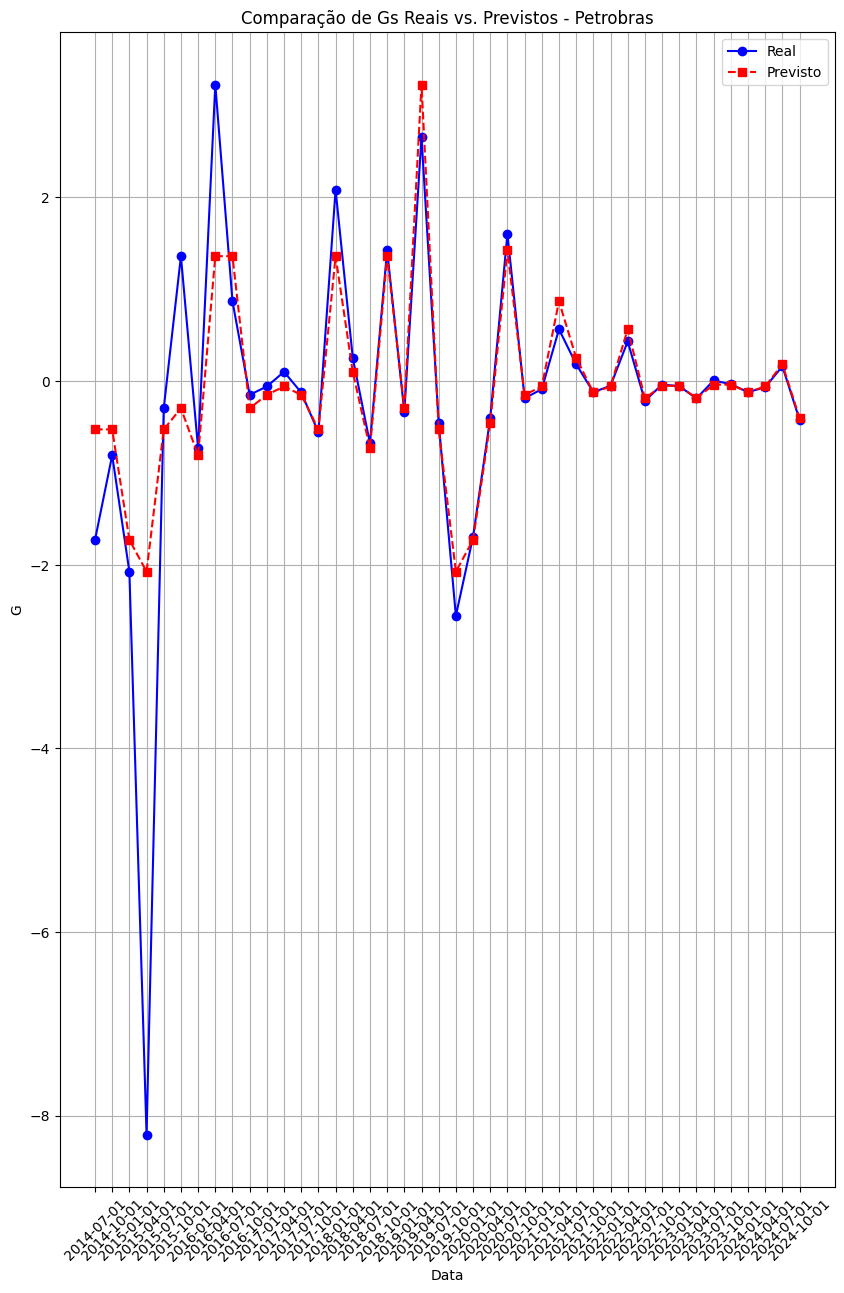

In [42]:
import matplotlib.pyplot as plt 

df_results = pd.read_csv('previsoes_knn_g.csv')
empresa_selecionada = 'Petrobras'
df_selecionado = df_results[df_results["Empresa"] == empresa_selecionada]

plt.figure(figsize=(10,15))
plt.plot(df_selecionado["Data"], df_selecionado["G Real"], label="Real", marker='o', linestyle='solid', color="blue")
plt.plot(df_selecionado["Data"], df_selecionado["G Previsto"], label="Previsto", marker='s', linestyle='dashed', color="red")

plt.xlabel("Data")
plt.ylabel("G")
plt.title(f"Comparação de Gs Reais vs. Previstos - {empresa_selecionada}")
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.grid(True)

plt.show()

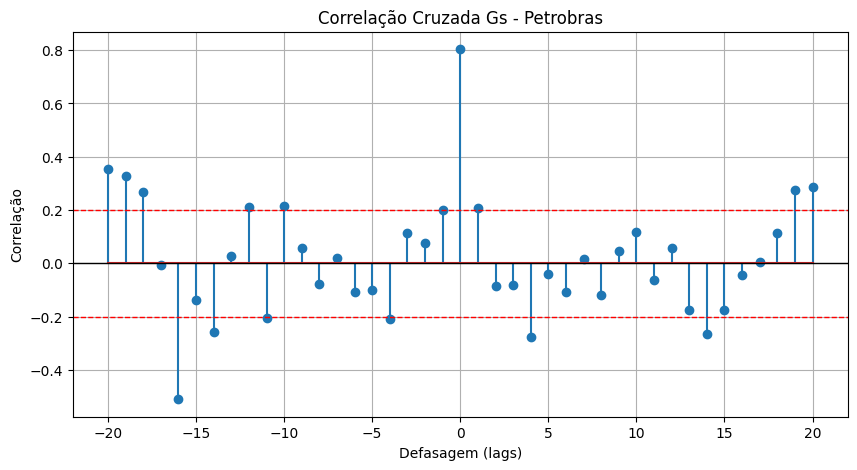

In [43]:
def cross_corr(x, y, lag=20):
    lags = np.arange(-lag, lag + 1)
    corr_values = []
    
    for l in lags:
        if l < 0:
            corr = np.corrcoef(x[:l], y[-l:])[0, 1]  # Quando o lag é negativo
        elif l > 0:
            corr = np.corrcoef(x[l:], y[:-l])[0, 1]  # Quando o lag é positivo
        else:
            corr = np.corrcoef(x, y)[0, 1]  # Quando lag = 0 (correlação normal)
        
        corr_values.append(corr)
    
    return lags, np.array(corr_values)

real = df_selecionado["G Real"]
previsto = df_selecionado["G Previsto"]

max_lag = 20 # Número máximo de defasagens a serem analisadas
lags, corr_values = cross_corr(real, previsto, max_lag)

plt.figure(figsize=(10, 5))
plt.stem(lags, corr_values)
plt.axhline(0, color='black', linewidth=1)
plt.axhline(0.2, color='red', linestyle='dashed', linewidth=1)
plt.axhline(-0.2, color='red', linestyle='dashed', linewidth=1)

plt.xlabel("Defasagem (lags)")
plt.ylabel("Correlação")
plt.title(f"Correlação Cruzada Gs - {empresa_selecionada}")
plt.grid(True)
plt.show()